# Segmentation of Zebrafish Gut using UNet

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# import multiprocessing
# import tifffile as tiff 
import skimage
# import skimage.io
# import skimage.exposure
# import skimage.morphology
# import skimage.measure
# import skimage.transform
# import skimage.segmentation
from PIL import Image, TiffTags

In [3]:
import tensorflow as tf
from tqdm import tqdm

Define helper functions

In [93]:
#function to enhance and show images
def show_image(img):
    fig = plt.figure(figsize=(25,20))
    img = np.array(img)
    enhance = skimage.exposure.equalize_hist(img)
    plt.imshow(enhance, cmap='gray')
    plt.axis("off")
    plt.show()
def show_image_overlapped(img, mask):
    img = np.array(img)
    mask = np.array(mask)
    fig = plt.figure(figsize=(25,20))
    img3 = 0.05*np.squeeze(mask) + 0.95*np.squeeze(img) #the ratio 0.5:0.95 was chosen by trail/error
    show_image(img3)
def save_image_overlapped(img, mask, save_path):
    img = np.array(img)
    mask = np.array(mask)
    img3 = skimage.exposure.equalize_hist(0.05*np.squeeze(mask) + 0.95*np.squeeze(img))
    skimage.io.imsave(save_path, skimage.img_as_ubyte(img3)) #using img_as_ubyte makes vals +ve

In [89]:
a=np.array([False])
a.astype(int)

array([0])

In [83]:
np.max(preds_test_t)

True

# Read Images

In [5]:
main_dir = '/home/piyush/Downloads/DATA/gut mask data/good/'

In [6]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 2**10 #actual image width = 6000
IMG_HEIGHT = 2**8 #actual image height = 2048
IMG_CHANNELS = 1 #grayscale image

In [7]:
TRAIN_PATH = main_dir + 'train/'
TEST_PATH = main_dir + 'test/'

In [8]:
train_mask_name, train_img_name = [], []

test_mask_name, test_img_name = [], []

for img_file in sorted(os.listdir(TRAIN_PATH)): 
    if img_file.endswith("BF_mask.tif"):
        train_mask_name.append(img_file)
    elif img_file.endswith("BF.png"):
        train_img_name.append(img_file)

for img_file in sorted(os.listdir(TEST_PATH)): 
    if img_file.endswith("BF_mask.tif"):
        test_mask_name.append(img_file)
    elif img_file.endswith("BF.png"):
        test_img_name.append(img_file)

In [9]:
print(f'Train Mask names:\n{train_mask_name}')

Train Mask names:
['14jul21_B1_BF_mask.tif', '14jul21_C1_BF_mask.tif', '14jul21_C4_BF_mask.tif', '14jul21_C5_BF_mask.tif', '14jul21_D5_BF_mask.tif', '14jul21_D6_BF_mask.tif', '15jul21_B1_BF_mask.tif', '15jul21_B2_BF_mask.tif', '15jul21_B3_BF_mask.tif', '15jul21_C1_BF_mask.tif', '15jul21_C4_BF_mask.tif', '15jul21_C5_BF_mask.tif', '15jul21_D5_BF_mask.tif', '15jul21_D6_BF_mask.tif', '16jul21_C4_BF_mask.tif', '16jul21_C5_BF_mask.tif', '16jul21_D5_BF_mask.tif', '16jul21_D6_BF_mask.tif', 'GF_13jul21_B1_BF_mask.tif', 'GF_13jul21_B2_BF_mask.tif', 'GF_13jul21_B3_BF_mask.tif', 'GF_13jul21_C1_BF_mask.tif', 'GF_13jul21_D5_BF_mask.tif', 'GF_13jul21_D6_BF_mask.tif']


In [10]:
print(f'Train Image names:\n{train_img_name}')

Train Image names:
['14jul21_B1_BF.png', '14jul21_C1_BF.png', '14jul21_C4_BF.png', '14jul21_C5_BF.png', '14jul21_D5_BF.png', '14jul21_D6_BF.png', '15jul21_B1_BF.png', '15jul21_B2_BF.png', '15jul21_B3_BF.png', '15jul21_C1_BF.png', '15jul21_C4_BF.png', '15jul21_C5_BF.png', '15jul21_D5_BF.png', '15jul21_D6_BF.png', '16jul21_C4_BF.png', '16jul21_C5_BF.png', '16jul21_D5_BF.png', '16jul21_D6_BF.png', 'GF_13jul21_B1_BF.png', 'GF_13jul21_B2_BF.png', 'GF_13jul21_B3_BF.png', 'GF_13jul21_C1_BF.png', 'GF_13jul21_D5_BF.png', 'GF_13jul21_D6_BF.png']


In [11]:
print(f'Test Image names:\n{test_img_name}')

Test Image names:
['14jul21_B2_BF.png', '14jul21_B3_BF.png', '16jul21_B1_BF.png', '16jul21_B2_BF.png', '16jul21_B3_BF.png', '16jul21_C1_BF.png', 'GF_13jul21_C4_BF.png', 'GF_13jul21_C5_BF.png']


In [12]:
print(f'Test Mask Name:\n{test_mask_name}')

Test Mask Name:
['14jul21_B2_BF_mask.tif', '14jul21_B3_BF_mask.tif', '16jul21_B1_BF_mask.tif', '16jul21_B2_BF_mask.tif', '16jul21_B3_BF_mask.tif', '16jul21_C1_BF_mask.tif', 'GF_13jul21_C4_BF_mask.tif', 'GF_13jul21_C5_BF_mask.tif']


In [13]:
img = skimage.io.imread(TRAIN_PATH + train_img_name[0], as_gray=True)

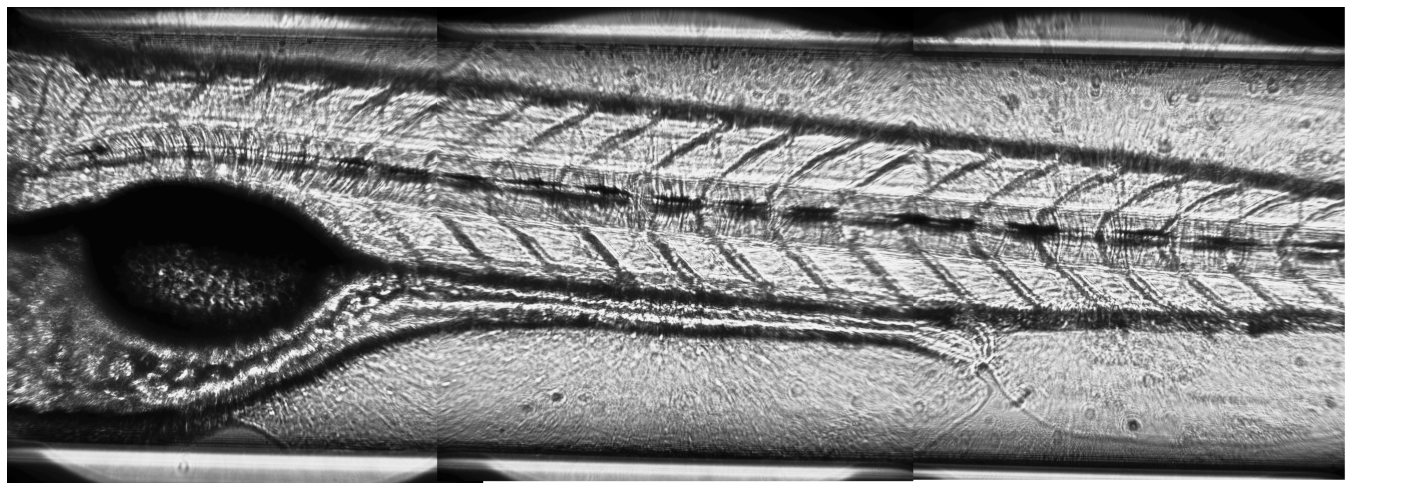

In [14]:
show_image(img)

In [15]:
img.shape

(2048, 6000)

the image size is too big for processing on our systems, so decreasing the size

In [16]:
# Load Train data into np arrays
X_train = np.zeros((len(train_img_name), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_train = np.zeros((len(train_img_name), IMG_HEIGHT, IMG_WIDTH), dtype=bool)
new_shape = (IMG_HEIGHT, IMG_WIDTH)

for i in tqdm(range(len(train_img_name))):
    img = skimage.io.imread(TRAIN_PATH + train_img_name[i], as_gray=True)# for converting to grayscale
    mask = skimage.io.imread(TRAIN_PATH + train_mask_name[i])

    # make small
    img_small = skimage.transform.resize(image=img, output_shape=new_shape)
    mask_small = skimage.transform.resize(image=mask, output_shape=new_shape, order=0) #order=0 for bool
    #put in arrays
    X_train[i,:,:,0] = img_small
    Y_train[i] = mask_small


100%|██████████| 24/24 [00:34<00:00,  1.44s/it]


In [17]:
##uncomment to run for the stats of the original train set (takes time)
# mean_xtrain = np.mean(X_train)
# std_xtrain = np.std(X_train)
# max_xtrain = np.max(X_train)
# min_xtrain = np.min(X_train)
# print(f'Stats of X_train: mean={mean_xtrain:.3f}, std={std_xtrain:.3f}, min={min_xtrain}, max={max_xtrain}')

Stats of original training data: mean=0.108, std=0.197, min=0.0, max=1.0

check read images

<Figure size 1800x1440 with 0 Axes>

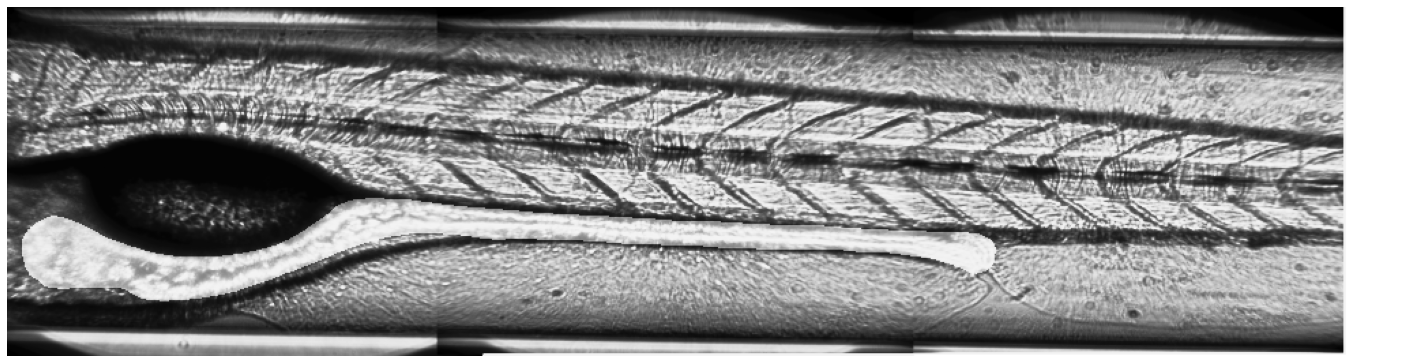

In [18]:
show_image_overlapped(X_train[0], Y_train[0])

In [19]:
# Load Test data into np arrays
X_test = np.zeros((len(test_img_name), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_test = np.zeros((len(test_img_name), IMG_HEIGHT, IMG_WIDTH), dtype=bool)
new_shape = (IMG_HEIGHT, IMG_WIDTH)

for i in tqdm(range(len(test_img_name))):
    img = skimage.io.imread(TEST_PATH + test_img_name[i], as_gray=True) #for converting to grayscale
    mask = skimage.io.imread(TEST_PATH + test_mask_name[i])

    # make small
    img_small = skimage.transform.resize(image=img, output_shape=new_shape)
    mask_small = skimage.transform.resize(image=mask, output_shape=new_shape, order=0) #order=0 for bool
    #put in arrays
    X_test[i,:,:,0] = img_small
    Y_test[i] = mask_small

100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


In [20]:
##uncomment for some stats of the test set
# print(np.mean(X_test), np.max(Y_test), np.min(Y_test))

# UNet Model

In [21]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#mean=0.11812, std=0.21466 of augmented dataset
s = tf.keras.layers.Lambda(lambda x: (x-0.11812)/0.21466)(inputs) #add normalization here

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

2022-03-10 00:27:44.503176: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# Uncomment the code below for tensorboard visualization
# import tensorboard

In [23]:
# from datetime import datetime
# # Define the Keras TensorBoard callback.
# logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# # Train the model.
# model_bce.fit(X_train, Y_train, validation_split=0.1, batch_size=None, epochs=10, callbacks=[tensorboard_callback]) #, batch_size=1, epochs=25

### Note about loss function: 
I tried dice and bce loss but didn't see any major difference between the two methods so just using the inbuilt bce loss with metrics of accuracy and pixelwise iou. 

In [24]:
# define and compile BCE model
model_bce = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_bce.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2),'accuracy'])
model_bce.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1024,   0           []                               
                                1)]                                                               
                                                                                                  
 lambda (Lambda)                (None, 256, 1024, 1  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 1024, 1  160         ['lambda[0][0]']                 
                                6)                                                            

See model architecture

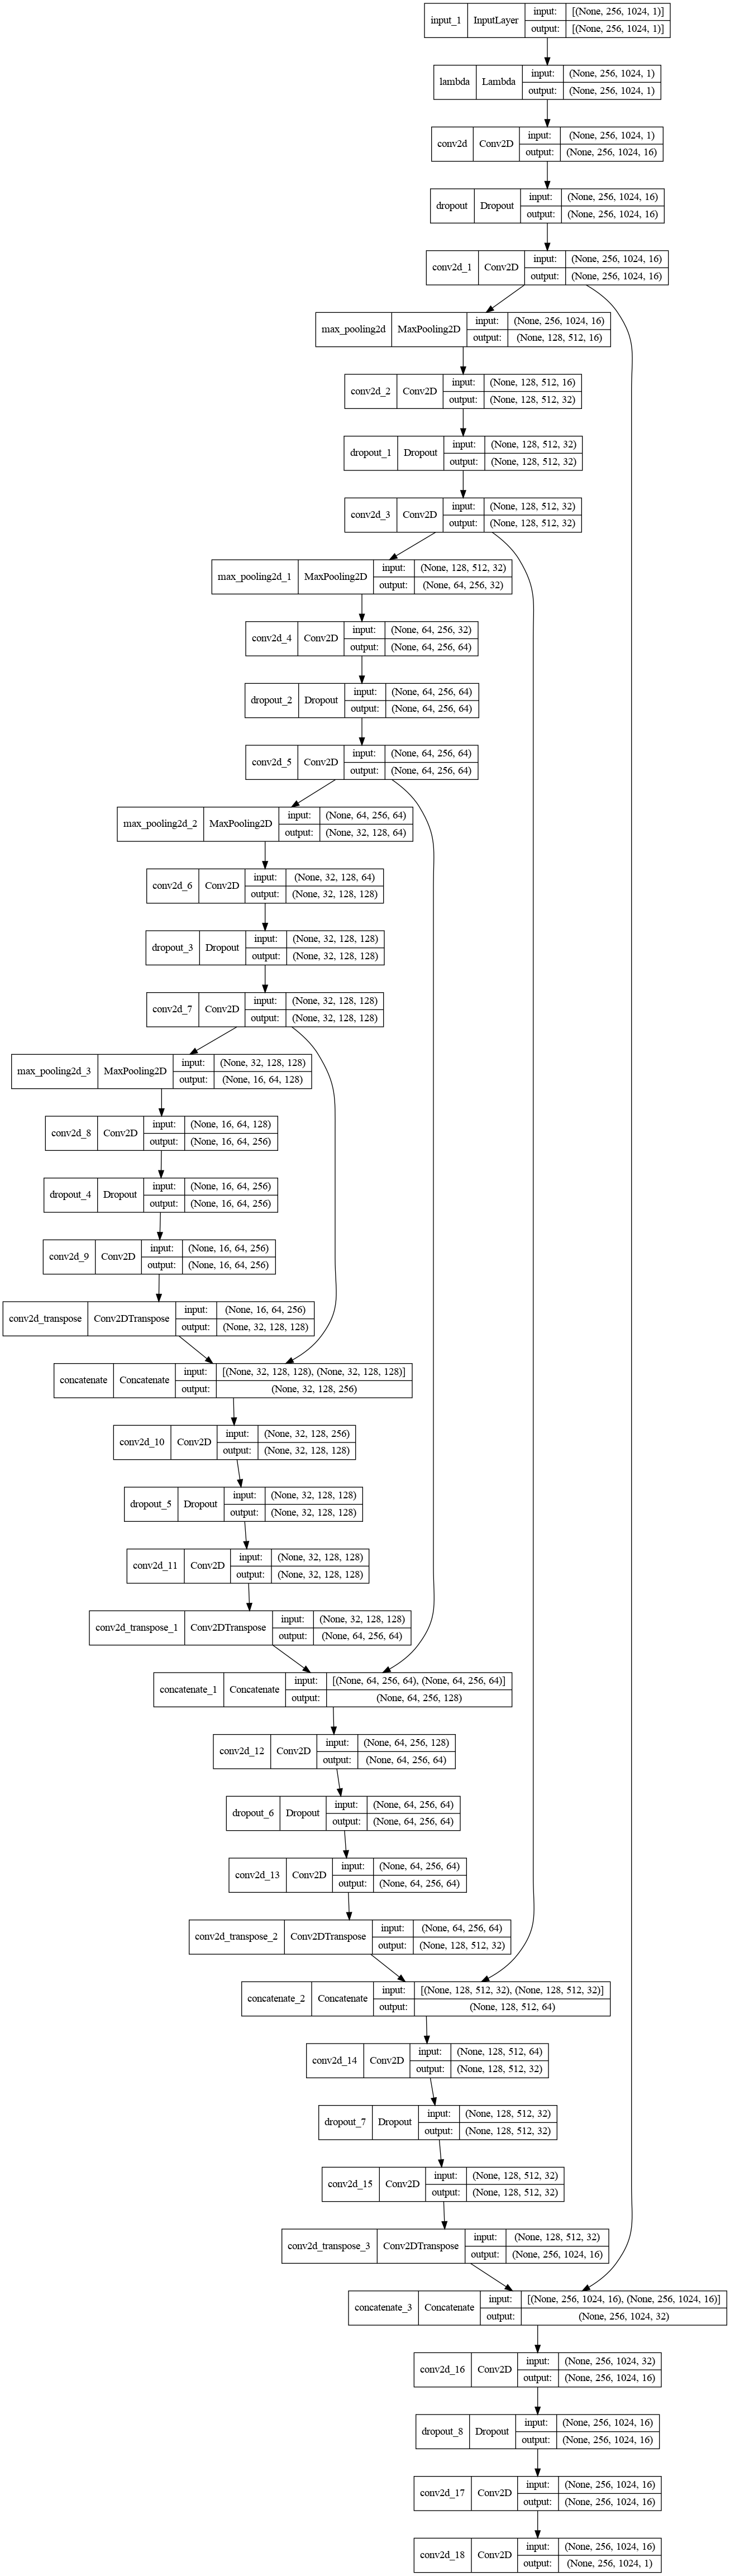

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model_bce, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Data Augmentation

In [26]:
X_train.shape

(24, 256, 1024, 1)

In [27]:
X_test.shape

(8, 256, 1024, 1)

Training set augmentation

In [28]:
X_train_tensor = tf.convert_to_tensor(X_train)
Y_train_tensor = tf.convert_to_tensor(Y_train)
Y_train_tensor = tf.expand_dims(Y_train_tensor, axis=-1)

# for i in range(len(X_train_tensor)):
#     seed = (2, 3) #seed for stateless random functions

#     # # #random horizontal flips
#     # if np.random.random>0.5:
#     #     aug_img = tf.image.flip_left_right(X_train_tensor[i])
#     #     aug_mask = tf.image.flip_left_right(Y_train_tensor[i])
#     # else:
#     #     aug_img = X_train_tensor[i]
#     #     aug_mask = Y_train_tensor[i]

#     aug_img = tf.image.stateless_random_flip_left_right(X_train_tensor[i], seed)
#     aug_mask = tf.image.stateless_random_flip_left_right(Y_train_tensor[i], seed)

#     aug_img = tf.expand_dims(aug_img, axis=0)
#     aug_mask = tf.expand_dims(aug_mask, axis=0)

#     X_train_tensor=tf.concat([X_train_tensor, aug_img], axis=0)
#     Y_train_tensor=tf.concat([Y_train_tensor, aug_mask], axis=0)

print('Adding random brightness:')

for i in range(len(X_train_tensor)):
    #random brightness
    aug_img = tf.image.random_brightness(X_train_tensor[i], max_delta=0.3)
    aug_mask = Y_train_tensor[i]#no brightness values for mask

    aug_img = tf.expand_dims(aug_img, axis=0)
    aug_mask = tf.expand_dims(aug_mask, axis=0)

    X_train_tensor = tf.concat([X_train_tensor, aug_img], axis=0)
    Y_train_tensor = tf.concat([Y_train_tensor, aug_mask], axis=0)

print('Adding random contrast:')

for i in range(len(X_train_tensor)):
    #random contrast
    aug_img = tf.image.random_contrast(X_train_tensor[i], 0.2, 0.5)
    aug_mask = Y_train_tensor[i]#no contrast value for mask

    aug_img = tf.expand_dims(aug_img, axis=0)
    aug_mask = tf.expand_dims(aug_mask, axis=0)

    X_train_tensor = tf.concat([X_train_tensor, aug_img], axis=0)
    Y_train_tensor = tf.concat([Y_train_tensor, aug_mask], axis=0)

n = len(X_train_tensor)

print('Adding random gaussian noise:')

for j in range(0, 30, 5):
    std = 0.01 + j*1e-4
    print(f'std: {std:.4f}')
    
    for i in tqdm(range(n)): #only go till n to prevent applying multiple noise to same image
        #add random noise
        noise = tf.random.normal(shape=tf.shape(X_train_tensor[i]), mean=0.0, stddev=std, dtype=tf.float64)
        aug_img = tf.add(X_train_tensor[i], noise)
        aug_mask = Y_train_tensor[i]#no noise added to the mask

        aug_img = tf.expand_dims(aug_img, axis=0)
        aug_mask = tf.expand_dims(aug_mask, axis=0)

        X_train_tensor = tf.concat([X_train_tensor, aug_img], axis=0)
        Y_train_tensor = tf.concat([Y_train_tensor, aug_mask], axis=0)

Adding random brightness:
Adding random contrast:
Adding random gaussian noise:
std: 0.0100


100%|██████████| 96/96 [00:04<00:00, 20.12it/s]


std: 0.0105


100%|██████████| 96/96 [00:08<00:00, 11.93it/s]


std: 0.0110


100%|██████████| 96/96 [00:11<00:00,  8.40it/s]


std: 0.0115


100%|██████████| 96/96 [00:13<00:00,  7.01it/s]


std: 0.0120


100%|██████████| 96/96 [00:16<00:00,  5.72it/s]


std: 0.0125


100%|██████████| 96/96 [00:19<00:00,  4.95it/s]


Test set augmentation

increase the test data size, by doing only "real world" data augmentation 

In [29]:
X_test_tensor = tf.convert_to_tensor(X_test)
Y_test_tensor = tf.convert_to_tensor(Y_test)
Y_test_tensor = tf.expand_dims(Y_test_tensor, axis=-1)

print('Adding random brightness:')

for i in range(len(X_test_tensor)):
    #random brightness
    aug_img = tf.image.random_brightness(X_test_tensor[i], max_delta=0.3)
    aug_mask = Y_test_tensor[i]#no brightness values for mask

    aug_img = tf.expand_dims(aug_img, axis=0)
    aug_mask = tf.expand_dims(aug_mask, axis=0)

    X_test_tensor = tf.concat([X_test_tensor, aug_img], axis=0)
    Y_test_tensor = tf.concat([Y_test_tensor, aug_mask], axis=0)

print('Adding random contrast:')

for i in range(len(X_test_tensor)):
    #random contrast
    aug_img = tf.image.random_contrast(X_test_tensor[i], 0.2, 0.5)
    aug_mask = Y_test_tensor[i]#no contrast value for mask

    aug_img = tf.expand_dims(aug_img, axis=0)
    aug_mask = tf.expand_dims(aug_mask, axis=0)

    X_test_tensor = tf.concat([X_test_tensor, aug_img], axis=0)
    Y_test_tensor = tf.concat([Y_test_tensor, aug_mask], axis=0)

n = len(X_test_tensor)

print('Adding random gaussian noise:')

for j in range(0, 30, 5):
    std = 0.01 + j*1e-4
    print(f'std: {std:.4f}')

    for i in tqdm(range(n)): #only go till n to prevent applying multiple noise to same image
        #add random noise
        noise = tf.random.normal(shape=tf.shape(X_test_tensor[i]), mean=0.0, stddev=std, dtype=tf.float64)
        aug_img = tf.add(X_test_tensor[i], noise)
        aug_mask = Y_test_tensor[i]#no noise added to the mask

        aug_img = tf.expand_dims(aug_img, axis=0)
        aug_mask = tf.expand_dims(aug_mask, axis=0)

        X_test_tensor = tf.concat([X_test_tensor, aug_img], axis=0)
        Y_test_tensor = tf.concat([Y_test_tensor, aug_mask], axis=0)

Adding random brightness:
Adding random contrast:
Adding random gaussian noise:
std: 0.0100


100%|██████████| 32/32 [00:00<00:00, 58.80it/s]


std: 0.0105


100%|██████████| 32/32 [00:00<00:00, 39.03it/s]


std: 0.0110


100%|██████████| 32/32 [00:01<00:00, 27.98it/s]


std: 0.0115


100%|██████████| 32/32 [00:01<00:00, 19.11it/s]


std: 0.0120


100%|██████████| 32/32 [00:01<00:00, 17.33it/s]


std: 0.0125


100%|██████████| 32/32 [00:02<00:00, 14.70it/s]


In [37]:
X_train_tensor.shape

TensorShape([672, 256, 1024, 1])

Stats of final augmented train set

Stats of X_train_tensor: mean=0.118, std=0.215, min=-0.344, max=1.339

In [38]:
# #uncomment to run for the stats of the augmented train set
# mean_xtrain_tensor = tf.math.reduce_mean(tf.squeeze(X_train_tensor))
# std_xtrain_tensor = tf.math.reduce_std(tf.squeeze(X_train_tensor))
# max_xtrain_tensor = tf.math.reduce_max(tf.squeeze(X_train_tensor))
# min_xtrain_tensor = tf.math.reduce_min(tf.squeeze(X_train_tensor))
# print(f'Stats of X_train_tensor: mean={mean_xtrain_tensor:.5f}, std={std_xtrain_tensor:.5f}, min={min_xtrain_tensor:.3f}, max={max_xtrain_tensor:.3f}')

In [39]:
# #uncomment to run for the stats of the augmented validation set
# mean_xtest_tensor = tf.math.reduce_mean(tf.squeeze(X_test_tensor))
# std_xtest_tensor = tf.math.reduce_std(tf.squeeze(X_test_tensor))
# max_xtest_tensor = tf.math.reduce_max(tf.squeeze(X_test_tensor))
# min_xtest_tensor = tf.math.reduce_min(tf.squeeze(X_test_tensor))
# print(f'Stats of X_test_tensor: mean={mean_xtrain_tensor:.5f}, std={std_xtrain_tensor:.5f}, min={min_xtrain_tensor:.3f}, max={max_xtrain_tensor:.3f}')

317


<Figure size 1800x1440 with 0 Axes>

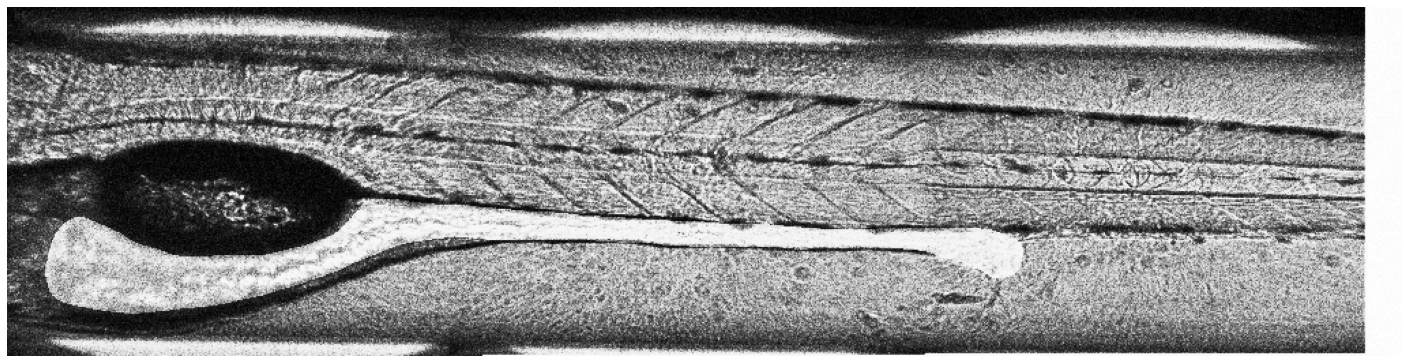

In [104]:
r = np.random.randint(0, len(X_train_tensor))
print(r)
show_image_overlapped(X_train_tensor[r], Y_train_tensor[r])

In [41]:
# shuffle test tensors as they aren't shuffled by inbuilt functions

indices = tf.range(start=0, limit=tf.shape(X_test_tensor)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

shuff_X_test_tensor = tf.gather(X_test_tensor, shuffled_indices)
shuff_Y_test_tensor = tf.gather(Y_test_tensor, shuffled_indices)

In [42]:
shuff_X_test_tensor.shape

TensorShape([224, 256, 1024, 1])

Image: 93


<Figure size 1800x1440 with 0 Axes>

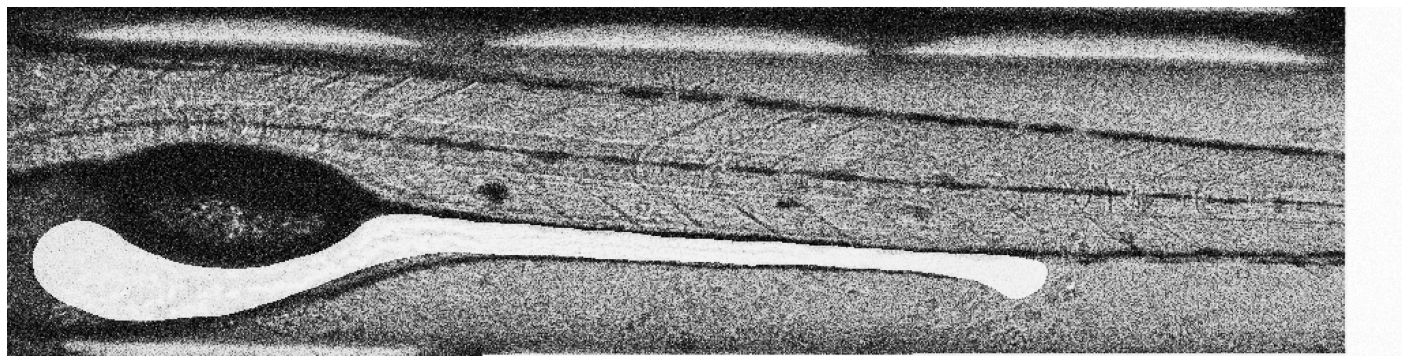

In [45]:
r = np.random.randint(0, len(X_test_tensor))
print(f'Image: {r}')
show_image_overlapped(shuff_X_test_tensor[r], shuff_Y_test_tensor[r]);

# Train

In [46]:
class MetricsCheckpoint(tf.keras.callbacks.Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [47]:
#Modelcheckpoint
earlystopper = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint('model-unet-aug-test-train-2.h5', verbose=1, save_best_only=True)
# Fit the model
history = model_bce.fit(X_train_tensor, Y_train_tensor, validation_data=(shuff_X_test_tensor, shuff_Y_test_tensor), epochs=32, batch_size=8, shuffle=True, callbacks = [earlystopper, checkpointer, MetricsCheckpoint('logs')])
#took 140mins in the last run

Epoch 1/32
84/84 [==============================] - ETA: 0s - loss: 0.3413 - mean_io_u: 0.4605 - accuracy: 0.9073
Epoch 00001: val_loss improved from inf to 0.27366, saving model to model-unet-aug-test-train-2.h5
84/84 [==============================] - 497s 6s/step - loss: 0.3413 - mean_io_u: 0.4605 - accuracy: 0.9073 - val_loss: 0.2737 - val_mean_io_u: 0.4613 - val_accuracy: 0.9226
Epoch 2/32
84/84 [==============================] - ETA: 0s - loss: 0.2289 - mean_io_u: 0.4605 - accuracy: 0.9209
Epoch 00002: val_loss improved from 0.27366 to 0.20481, saving model to model-unet-aug-test-train-2.h5
84/84 [==============================] - 496s 6s/step - loss: 0.2289 - mean_io_u: 0.4605 - accuracy: 0.9209 - val_loss: 0.2048 - val_mean_io_u: 0.4613 - val_accuracy: 0.9226
Epoch 3/32
84/84 [==============================] - ETA: 0s - loss: 0.2114 - mean_io_u: 0.4605 - accuracy: 0.9210
Epoch 00003: val_loss improved from 0.20481 to 0.20196, saving model to model-unet-aug-test-train-2.h5
84/84

dict_keys(['loss', 'mean_io_u', 'accuracy', 'val_loss', 'val_mean_io_u', 'val_accuracy'])


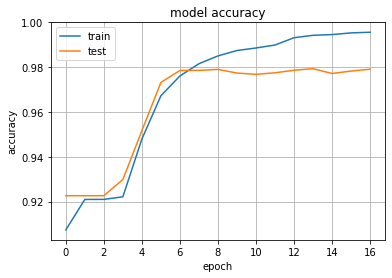

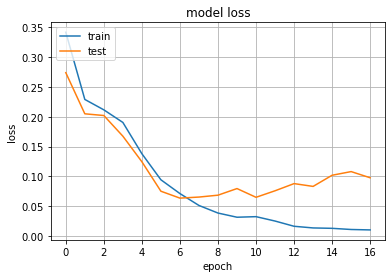

In [99]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# fig = plt.figure(dpi=200) #uncomment for saving at high dpi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.ylim(0.8, 1.00)
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
# plt.savefig('model_accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim(0, 0.20)
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
# # summarize history for mean_iou
# plt.plot(history.history['mean_io_u'])
# plt.plot(history.history['val_mean_io_u'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# # plt.ylim(0.8, 1.00)
# plt.legend(['train', 'test'], loc='upper left')
# plt.grid()
# plt.show()

# Test Accuracy

In [49]:
model_bce.evaluate(X_test, Y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.0961 - mean_io_u: 0.7300 - accuracy: 0.9808


[0.09608576446771622, 0.7300146222114563, 0.9808464050292969]

In [50]:
model_bce.evaluate(X_test_tensor, Y_test_tensor)

7/7 [==============================] - 36s 5s/step - loss: 0.0978 - mean_io_u: 0.6539 - accuracy: 0.9791


[0.09780408442020416, 0.6539135575294495, 0.9791331887245178]

Good accuracy of 97-98%, let's visualize the masks created

# See Predictions

In [59]:
y_pred = tf.squeeze(model_bce.predict(X_test))
y_pred.shape

TensorShape([8, 256, 1024])

In [60]:
Y_test.shape

(8, 256, 1024)

In [65]:
preds_test_t = (y_pred > 0.99)#.astype(np.bool8)
# show_image(preds_test_t[3])
# show_image_overlapped(np.squeeze(X_test[0]),np.squeeze(preds_test_t[0]))

Test Image: 3


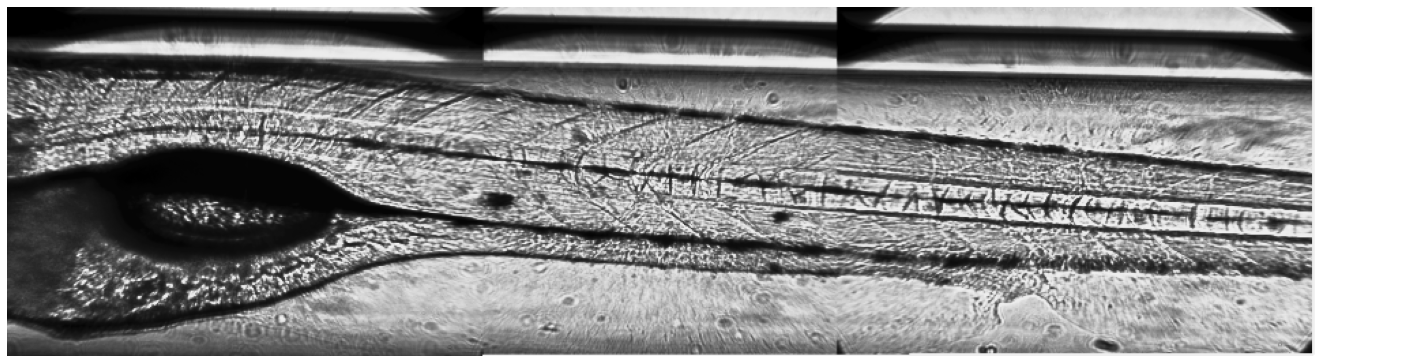

Predicted Mask


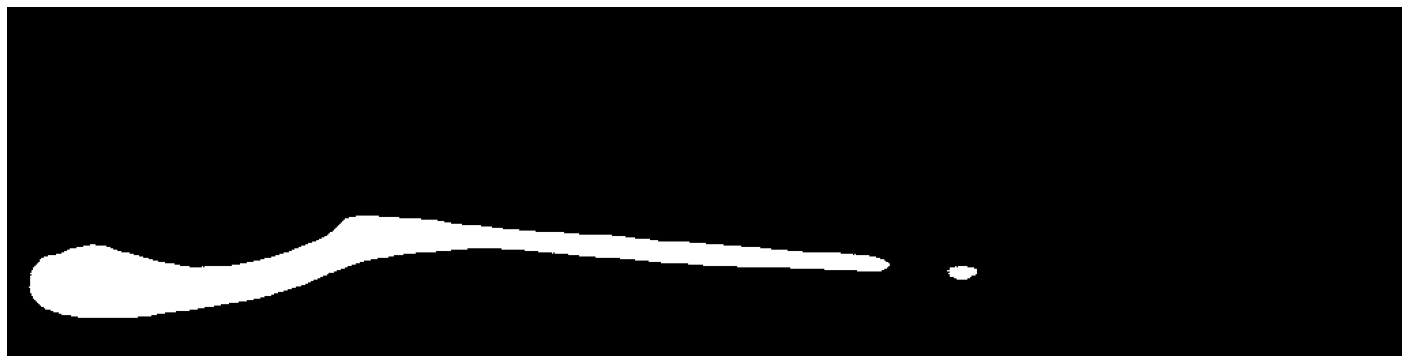

Predicted Mask overlaid


<Figure size 1800x1440 with 0 Axes>

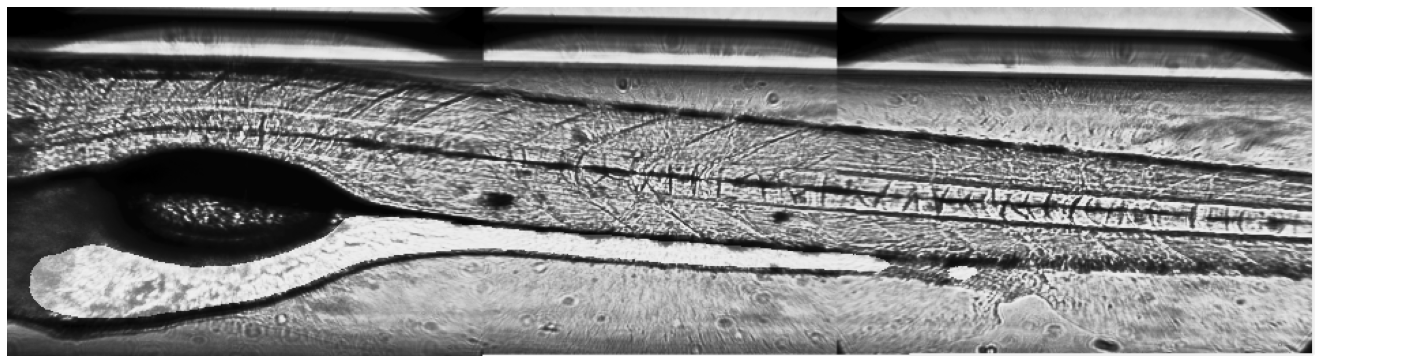

GT Mask overlaid


<Figure size 1800x1440 with 0 Axes>

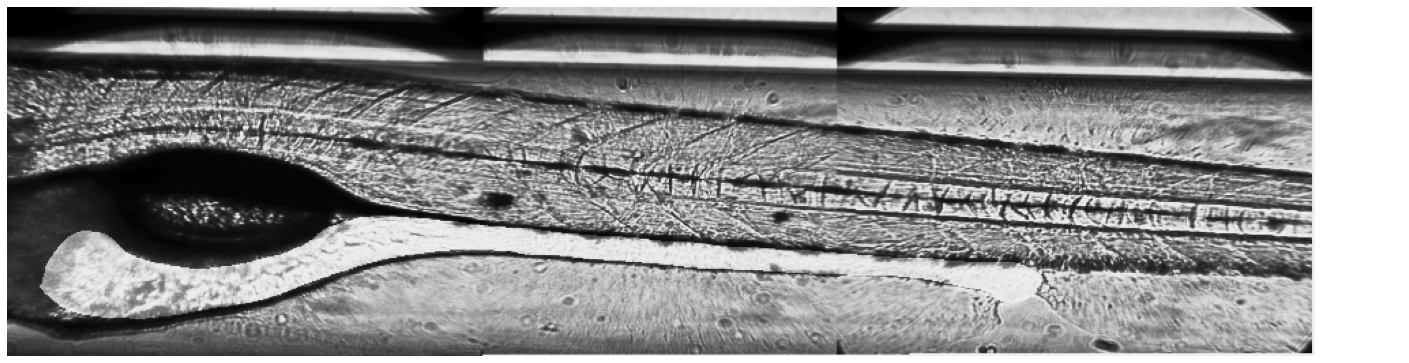

In [66]:
r=np.random.randint(0,8)
print(f'Test Image: {r}')
show_image(X_test[r])
plt.show()
print('Predicted Mask')
show_image(preds_test_t[r])
plt.show()
print('Predicted Mask overlaid')
show_image_overlapped(X_test[r],preds_test_t[r])
plt.show()
print('GT Mask overlaid')
show_image_overlapped(X_test[r], Y_test[r])

In [67]:
# save predicted images
for i, img in enumerate(preds_test_t):
    skimage.io.imsave(f'./prediction_600_shuff_v2/0.99_{i}.png', skimage.img_as_ubyte(img))

In [94]:
# save overlapped images
for i in range(len(X_test)):
    save_image_overlapped(img=X_test[i], mask=preds_test_t[i], save_path=f'./prediction_600_shuff_v2/0.99_overlapped_{i}.png')

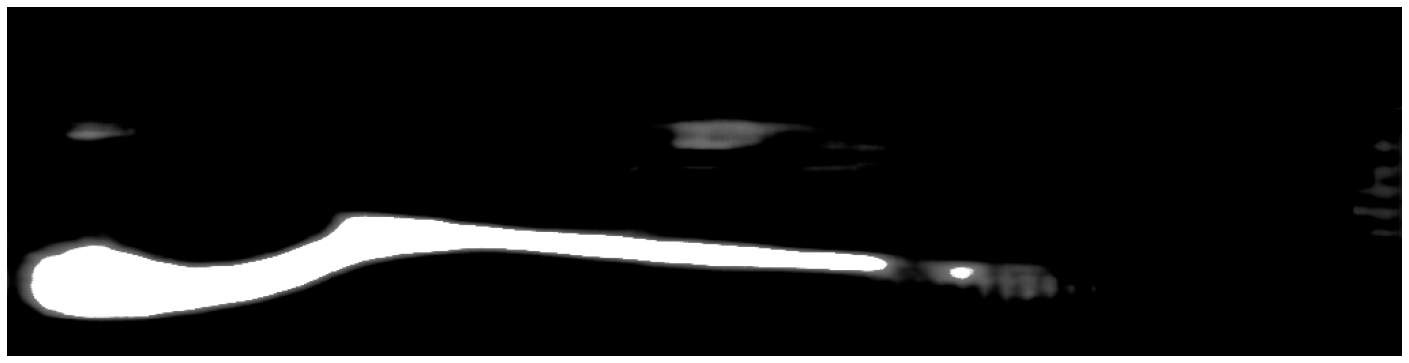

In [68]:
test_img=np.squeeze(y_pred[3])
show_image(test_img)

---

# Appendix:
Comparison of bce and dice loss

In [58]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    dice_loss = 1 - numerator / denominator
    # dice_score = dice_loss(y_true, y_pred)
    # bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    return tf.reduce_mean(dice_loss) #bce_loss +

In [81]:
dice_l=[]
for i in range(len(Y_test)):
    dice_l.append(dice_loss(Y_test[i], tf.squeeze(preds_test_t[i])))

In [82]:
bce_l = []
for i in range(len(Y_test)):
    bce_l.append(tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(Y_test[i], y_pred[i])))


Text(0, 0.5, 'bce loss')

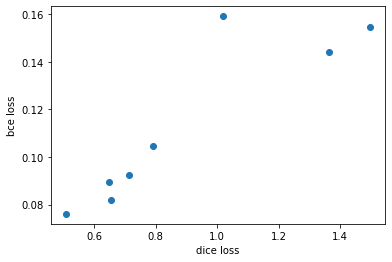

In [86]:
plt.scatter(dice_l, bce_l)
plt.xlabel('dice loss')
plt.ylabel('bce loss')

In [87]:
np.corrcoef(dice_l,bce_l)

array([[1.       , 0.8981321],
       [0.8981321, 1.       ]])

Trying with a bigger prediction set

In [95]:
y_pred_tensor = model_bce.predict(X_test_tensor)
y_pred_tensor.shape

(224, 256, 1024, 1)

In [96]:
preds_test_tensor = (tf.squeeze(y_pred_tensor) > 0.5)#.astype(np.bool8)
preds_test_tensor

<tf.Tensor: shape=(224, 256, 1024), dtype=bool, numpy=
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False

In [97]:
dice_l=[]
for i in range(len(Y_test_tensor)):
    dice_l.append(bce_dice_loss(tf.squeeze(Y_test_tensor[i]), tf.squeeze(preds_test_tensor[i])))

In [98]:
bce_l = []
for i in range(len(Y_test_tensor)):
    bce_l.append(tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(Y_test_tensor[i], y_pred_tensor[i])))


Text(0, 0.5, 'bce loss')

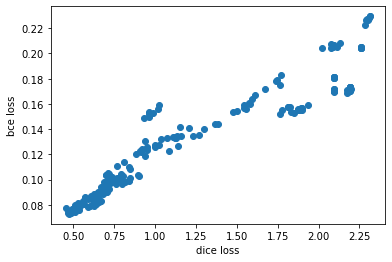

In [99]:
plt.scatter(dice_l, bce_l)
plt.xlabel('dice loss')
plt.ylabel('bce loss')

In [100]:
np.corrcoef(dice_l,bce_l)

array([[1.       , 0.9517455],
       [0.9517455, 1.       ]])

There is very high correlation between the two, only a difference of 0.1. So they are identical in identifying bad images.

---